# Import Library

In [1]:
# 整理資料
import pandas as pd
import numpy as np

# 繪圖
import matplotlib.pyplot as plt

# 日期時間
import datetime as dt

# 產生隨機數
import random

# 進度列，舉例如下
# 完成百分比|Progress Bar| 目前項目/總項目 [經過時間<預計完成時間(ETA), 處理速率]
# 100%|██████████| 7178/7178 [00:04<00:00, 1534.93it/s]
import tqdm

# 檔案系統存取
from pathlib import Path

# 深度學習函式庫
from keras.utils import np_utils
from keras.models import Sequential, Model, model_from_json, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


# Clean & Process Data

In [2]:
# Import data
input_data_x = pd.read_csv('./train_X.csv')

input_data_y = pd.read_csv('./all_label.csv')
input_data_y = input_data_y.drop('user_id', axis=1)

train_data = pd.concat([input_data_x, input_data_y], axis=1)
# Preview data shape
print('讀入資料形狀為(列, 欄):', train_data.values.shape)

# check N/A data (must = 0)
print('\nN/A data:\n' + str(train_data.isnull().sum()))

# Preview Shuffled data
train_data.head()

讀入資料形狀為(列, 欄): (57159, 30)

N/A data:
id              0
feature         0
time_slot_0     0
time_slot_1     0
time_slot_2     0
time_slot_3     0
time_slot_4     0
time_slot_5     0
time_slot_6     0
time_slot_7     0
time_slot_8     0
time_slot_9     0
time_slot_10    0
time_slot_11    0
time_slot_12    0
time_slot_13    0
time_slot_14    0
time_slot_15    0
time_slot_16    0
time_slot_17    0
time_slot_18    0
time_slot_19    0
time_slot_20    0
time_slot_21    0
time_slot_22    0
time_slot_23    0
time_slot_24    0
time_slot_25    0
time_slot_26    0
time_slot_27    0
dtype: int64


,id,feature,time_slot_0,time_slot_1,time_slot_2,time_slot_3,time_slot_4,time_slot_5,time_slot_6,time_slot_7,...,time_slot_18,time_slot_19,time_slot_20,time_slot_21,time_slot_22,time_slot_23,time_slot_24,time_slot_25,time_slot_26,time_slot_27
0,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
4,4,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def split_data(VALIDATION_SIZE, source_feature, source_label, normalize = True):
    if (len(source_feature) != len(source_label)):
        raise Exception('Feature length not equals Label length!!')
        
    VALIDATION_SIZE = int(round(VALIDATION_SIZE * len(source_feature), 0))
    #print(VALIDATION_SIZE)
    
    x = np.vstack(source_feature.apply(lambda im: np.fromstring(im, sep=' ')).values)
    y = np.array(source_label)
    
    # Normalize [0:255] to [0:1]
    # 可提升準確率且可加快收斂速率
    if (normalize):
        x = np.multiply(x, 1.0/255.0)
    
    x_train = x[VALIDATION_SIZE:]
    y_train = y[VALIDATION_SIZE:]

    print('The number of final training data: %d'%(len(x_train)))
    print(x_train.shape, y_train.shape)
    
    x_vaild = x[:VALIDATION_SIZE]
    y_vaild = y[:VALIDATION_SIZE]

    print('\nThe number of final validation data: %d'%(len(x_vaild)))
    print(x_vaild.shape, y_vaild.shape)
    
    return x_train ,y_train, x_vaild, y_vaild

In [4]:
# shuffle the rows
train_data = train_data.iloc[np.random.permutation(len(train_data))]

x_train ,y_train, x_vaild, y_vaild = split_data(0.05, train_data['feature'], train_data.iloc[:, 2:30], False)

The number of final training data: 54301
(54301, 924) (54301, 28)

The number of final validation data: 2858
(2858, 924) (2858, 28)


In [5]:
# 將feature重新塑形成為 [輸入圖像數，圖像寬度，圖像高度，色彩通道數(每一色彩 1bit)]
height = 33 
width = 28

x_train = x_train.reshape(-1, height, width, 1)
x_vaild = x_vaild.reshape(-1, height, width, 1)
x_train.shape, x_vaild.shape

((54301, 33, 28, 1), (2858, 33, 28, 1))

In [6]:
# 將label重新塑形成為 One-hot表示法
#y_train = np_utils.to_categorical(y_train)
#y_vaild = np_utils.to_categorical(y_vaild)
y_train.shape, y_vaild.shape

((54301, 28), (2858, 28))

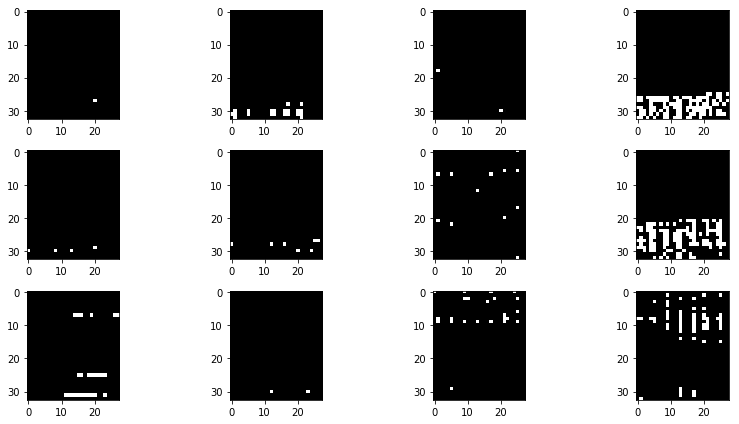

In [7]:
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

# Build Model！

In [8]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3),
                input_shape=(height, width ,1),
                activation='relu',
                padding='same'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3),
                activation='relu',
                padding='same'))
model.add(Dropout(rate=0.25))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(rate=0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(28, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

print(model.summary())

# WARNING: ...... keep_dims is deprecated, use keepdims instead will be repaired by keras.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 33, 28, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 14, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 7, 64)          0      

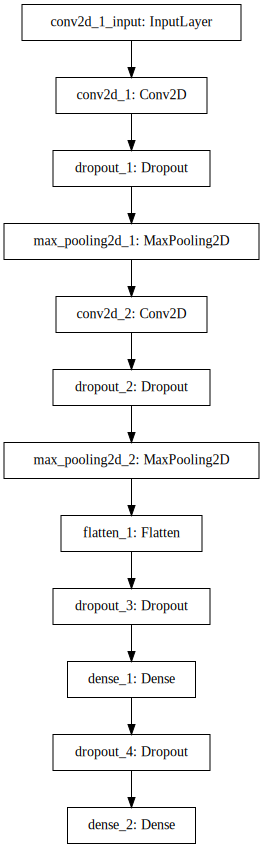

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# save best weights
output_dir = './' + dt.datetime.now().strftime("%Y%m%d")
path = Path(output_dir)
if not path.exists():
    path.mkdir()

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog="dot", format="svg"))

In [11]:
# returns a compiled model
# identical to the previous one
#model = load_model('.//keras_tf_easy//20171103002518_model_final.h5')

In [12]:

checkpointer = ModelCheckpoint(filepath=output_dir + '//model.h5', verbose=1, save_best_only=True)

#ValueError: If printing histograms, validation_data must be provided, and cannot be a generator.

#embeddingsMetadata = {'conv2d_2': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir=output_dir, histogram_freq=0, write_graph=True, write_images=False)
                          #embeddings_freq=10, embeddings_layer_names = ['conv2d_2'])
                          #embeddings_metadata=embeddingsMetadata)

# Total epoch = times x step
times = 1
step = 20

for i in range(0, 0 + times):
    # num epochs (each epoch about spent 10 mins.)
    epochs = i * step + step
    
    hist = model.fit(x_train, y_train, epochs=epochs, initial_epoch= i * step,
                        batch_size=100,validation_data=(x_vaild, y_vaild),
                        callbacks=[checkpointer, tensorboard], verbose = 1)

    '''
    # run model
    hist = model.fit(x_train, y_train, epochs=epochs,
                     shuffle=True,
                     batch_size=100, validation_data=(x_vaild, y_vaild),
                     callbacks=[checkpointer], verbose=2)
    '''

    # create dt object
    dtNow = dt.datetime.now().strftime("%Y%m%d%H%M%S");

    # save model arch to json
    model_json = model.to_json()
    with open(output_dir + "//" + dtNow + "_face_model.json", "w") as json_file:
        json_file.write(model_json)

    # evaluate model
    score = model.evaluate(x_vaild, y_vaild, verbose=0)

    # save final model
    pathStr = output_dir + '//' + dtNow + '_face_model_final_' + str(round(score[1], 6)) + '.h5'
    model.save(pathStr)  # creates a HDF5 file
    print('Model saved to: {0}'.format(pathStr))

score

Train on 54301 samples, validate on 2858 samples
Epoch 1/20
54301/54301 [==============================] - 7s 135us/step - loss: 0.1817 - acc: 0.9337 - val_loss: 0.1411 - val_acc: 0.9535
Epoch 2/20
54301/54301 [==============================] - 7s 122us/step - loss: 0.1323 - acc: 0.9553 - val_loss: 0.1228 - val_acc: 0.9660
Epoch 3/20
54301/54301 [==============================] - 7s 125us/step - loss: 0.1197 - acc: 0.9617 - val_loss: 0.1120 - val_acc: 0.9703
Epoch 4/20
54301/54301 [==============================] - 7s 123us/step - loss: 0.1126 - acc: 0.9649 - val_loss: 0.1077 - val_acc: 0.9711
Epoch 5/20
54301/54301 [==============================] - 6s 117us/step - loss: 0.1076 - acc: 0.9669 - val_loss: 0.1082 - val_acc: 0.9726
Epoch 6/20
54301/54301 [==============================] - 7s 124us/step - loss: 0.1043 - acc: 0.9683 - val_loss: 0.1041 - val_acc: 0.9738
Epoch 7/20
54301/54301 [==============================] - 6s 117us/step - loss: 0.1010 - acc: 0.9693 - val_loss: 0.1000 - v

[0.095733140649350901, 0.97422024422045606]

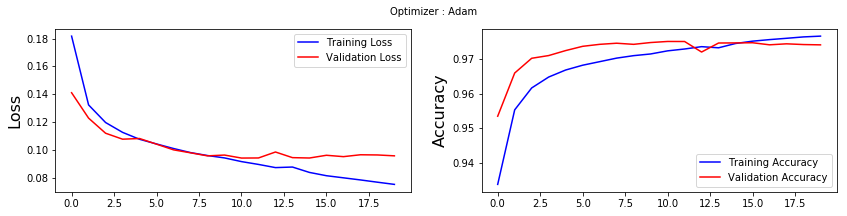

In [13]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [14]:
print(x_vaild[3], y_vaild[3])
predicted_probs = model.predict(x_vaild[3].reshape(-1, height, width, 1))
predicted_probs[predicted_probs>=0.5] = 1
predicted_probs[predicted_probs<0.5] = 0

[[[ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]


In [16]:
confusion_matrix = np.zeros((28, 28))

misclassified = [list() for i in range(28)]
#print(misclassified)
answerCount = [0] * 28

for image_id, image in tqdm.tqdm(enumerate(zip(x_vaild,y_vaild)), total=len(x_vaild)):
    predicted_probs = model.predict(image[0].reshape(-1, height, width, 1))
    #predicted = np.argmax(predicted_probs)
    #answer = np.argmax(image[1])
    predicted_probs[predicted_probs>=0.5] = 1
    predicted_probs[predicted_probs<0.5] = 0
    
    #print(image[1])
    #print(predicted_probs[0].astype(int))
    #print(predicted_probs[0] == image[1])
    
    #raise
    
    for i in range(0, len(answerCount)):
        if (image[1][i] == 1):
            answerCount[i]+=1

        if (image[1][i] != predicted_probs[0][i]):
            misclassified[i].append((image[0], image[1]))

100%|██████████| 2858/2858 [00:01<00:00, 1676.94it/s]


In [17]:
#print(misclassified[1])
time_slots = list(range(0, 28))
total_misclassified_items = 0
total_items = 0
for time_slots_id, time_slots_name in enumerate(time_slots):
    total_misclassified_items += len(misclassified[time_slots_id])
    total_items += answerCount[time_slots_id]
    print("{0} - {1} out of {2} ({3}%) misclassified".format(time_slots_name, len(misclassified[time_slots_id]),
                                                             answerCount[time_slots_id], round((len(misclassified[time_slots_id])/answerCount[time_slots_id]) * 100, 3)))
    
print("Total - {0} out of {1} ({2}%) misclassified".format(total_misclassified_items, total_items, round((total_misclassified_items / total_items) * 100, 3)))

0 - 77 out of 307 (25.081%) misclassified
1 - 94 out of 472 (19.915%) misclassified
2 - 33 out of 132 (25.0%) misclassified
3 - 71 out of 118 (60.169%) misclassified
4 - 88 out of 358 (24.581%) misclassified
5 - 96 out of 459 (20.915%) misclassified
6 - 40 out of 134 (29.851%) misclassified
7 - 76 out of 118 (64.407%) misclassified
8 - 82 out of 351 (23.362%) misclassified
9 - 95 out of 497 (19.115%) misclassified
10 - 37 out of 120 (30.833%) misclassified
11 - 79 out of 111 (71.171%) misclassified
12 - 80 out of 302 (26.49%) misclassified
13 - 97 out of 470 (20.638%) misclassified
14 - 42 out of 121 (34.711%) misclassified
15 - 73 out of 109 (66.972%) misclassified
16 - 80 out of 329 (24.316%) misclassified
17 - 112 out of 449 (24.944%) misclassified
18 - 42 out of 123 (34.146%) misclassified
19 - 97 out of 120 (80.833%) misclassified
20 - 103 out of 353 (29.178%) misclassified
21 - 108 out of 435 (24.828%) misclassified
22 - 41 out of 147 (27.891%) misclassified
23 - 79 out of 108 (7

In [ ]:
show_disease = 1

if len(misclassified[2]) == 0:
    print("no images to show")
else:
    print('Total of images: ', len(misclassified[show_disease]), ', Total of lebals: ', len(misclassified[show_disease]))
    #print(cls_true)
    
    random_indices = random.sample(range(len(misclassified[show_disease])), min(len(misclassified[show_disease]), 25))
    #random_indices = list(range(25))
    
    print(random_indices)

# Create figure with 5x5 sub-plots.
fig, axes = plt.subplots(5, 4)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.set_size_inches(20, 15)

for i, ax in enumerate(axes.flat):
    #print(i, ax, enumerate(axes.flat))
    
    # Plot image.
    ax.imshow(misclassified[show_disease][random_indices[i]][0][:, :, 0], cmap='gray')

    xlabel = "Index: {0}, True: ({1}){2}, Pred: ({3}){4}".format(
                random_indices[i], np.argmax(misclassified[show_disease][i][1]),
                diseases[np.argmax(misclassified[show_disease][i][1])], 
                misclassified[show_disease][i][2], diseases[misclassified[show_disease][i][2]])

    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)
    
    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])

# Ensure the plot is shown correctly with multiple plots
# in a single Notebook cell.
plt.show()

In [ ]:
fig = plt.figure()
fig.set_size_inches(30, 30)
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)

#normalized = np.array(confusion_matrix) / confusion_matrix.sum(axis = 1) * 100
normalized = np.array([[0.]*28]*28)

for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix[i])):
        normalized[i][j] = round(confusion_matrix[i][j] / confusion_matrix.sum (axis = 1) [i] * 100, 2)
    
total = np.array(confusion_matrix)

#print(confusion_matrix.sum(axis=1),"\n",np.array(confusion_matrix))
#print(normalized)

res = ax.imshow(np.array(normalized), cmap="Blues", 
                interpolation="nearest")
height, width = confusion_matrix.shape
cb = fig.colorbar(res)
for x in range(width):
    for y in range(height):
        ax.annotate(str(int(total[x][y])) + "\n(" + str(normalized[x][y]) + "%)", xy=(y, x), 
                    horizontalalignment="center",
                    verticalalignment="center", 
                    fontsize=12)

plt.xlabel('Predict', fontsize=15)
plt.ylabel('Actural', fontsize=15)
plt.xticks(range(width), diseases, rotation="vertical", fontsize=15);
plt.yticks(range(height), diseases, fontsize=15);
plt.show()

# Testing

In [ ]:
test_data = pd.read_csv('.//train_X.csv')
print(test_data.values.shape)
test_data.head()

In [ ]:
# split data into testing
x_test = np.vstack(train_data['feature'].apply(lambda im: np.fromstring(im, sep=' ')).values)

# [0:255] to [0:1]
#x_test = np.multiply(x_test,1.0/255.0)

print('The number of final testing data: %d'%(len(x_test)))
x_test.shape

In [ ]:
x_test = x_test.reshape(-1, 33, 28, 1)
x_test.shape

In [ ]:
if (len(x_test) < 13):
    max_show = len(x_test) + 1
else:
    max_show = 13

plt.figure(0, figsize=(16, 8))
for i in range(1, max_show):
    plt.subplot(3, 6, i)
    plt.imshow(x_test[i - 1, :, :, 0])

plt.tight_layout()
plt.show()

In [ ]:
image_idx = 0
predicted_probs = model.predict(x_test[image_idx:image_idx + 1, : , : ,0:1])
predicted_probs

In [ ]:
predicted_lables = []

for image_id, image in tqdm.tqdm(enumerate(x_test), total = len(x_test)):   
    predicted_probs = model.predict(image.reshape(-1, height, width, 1))
    predicted = np.argmax(predicted_probs)
    predicted_lables.append(predicted)

In [ ]:
#print("Index:", "0:Angry", "1:Disgust", "2:Fear", "3:Happy", "4:Sad", "5:Surprise", "6:Neutral")
#print('Total: {0}, Result: {1}'.format(len(predicted_lables), predicted_lables))

'''
# save results
np.savetxt('hw3_keras8_submission_softmax.csv',
           np.c_[range(0,len(x_test)),predicted_lables],
           delimiter=',',
           header = 'id,label',
           comments = '',
           fmt='%d')
'''
correct = 0

for idx, element in enumerate(train_data['label']):
    if (element == predicted_lables[i]):
        correct = correct + 1

print('Test accuracy:{0}%'.format(correct / len(predicted_lables) * 100))
        